# Modelo SchNet (Pytorch)


*   n_atom_basis=30
*   n_filters=30
*   n_gaussians=20
*   n_interactions=5
*   cutoff=4.
*   cutoff_network=HardCutoff
*   SGD 1e-2 momentum=0.9
*   ReduceLROnPlateauHook hasta 1e-6



In [ ]:
!pip install schnetpack
!pip install ase
!pip install nglview
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pandas as pd
from  schnetpack import AtomsData
import schnetpack as spk
import schnetpack.train as trn
from ase.io import read
from ase.visualize.plot import plot_atoms
from ase.lattice.cubic import FaceCenteredCubic
from torch.optim import Adam, SGD
import torch
qmH2O = '/content/drive/My Drive/Colab Notebooks/SchNet Files/qmH2O_7/'
SchNet_Files = '/content/drive/My Drive/Colab Notebooks/SchNet Files/'
Files = '/content/drive/My Drive/Colab Notebooks/'

# DB ASE 
Se carga DB ASE si existe(SQL Lite para átomos y moléculas), en caso contrario se crea el fichero de DB vacío 

In [ ]:
new_dataset = AtomsData(SchNet_Files + 'new_dataset_H2O.db')

# Carga de datos en DB a partir de fichero en formato xyz
# Comentado! 
Esto se hace una vez en local y sirve para todos los entrenamnientos

1.   Se importa el archivo xyz con la información de las 
moléculas y sus propiedades. En nuestro caso:
*   Posición de los átomos
*   Energía



In [ ]:
#atoms = read('/content/drive/My Drive/Colab Notebooks/output_h2o_HF_ccpvdz_to_SchNet.xyz', index=':17636')
#print(len(atoms))

17636


2.   Se pueden visualizar las moléculas



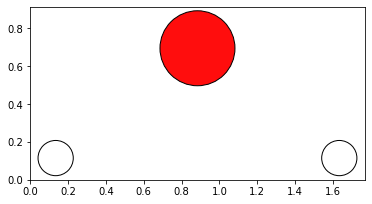

In [ ]:
#fig, ax = plt.subplots()
#plot_atoms(atoms[12852], ax, radii=0.3, rotation=('0x,0y,-90z'))

3.   Se crea una lista, solo con las propiedades que no sean posiciones espaciales o vectores de fuerza. En nuestro caso la energía.

In [ ]:
#print('Energy:', atoms[12852].info)

# parse properties as list of dictionaries
#property_list = []
#for at in atoms:
#    energy = np.array([float(list(at.info.keys())[0])], dtype=np.float32)
#    property_list.append(
#        {'energy': energy}
#    )
#print(property_list[12852])
#len(property_list)

Energy: {'-76.027388': True}
{'energy': array([-76.02739], dtype=float32)}


17636

4.   Se carga la información en la DB de forma persistente


In [ ]:
#new_dataset.add_systems(atoms, property_list)

# Creación del conjunto de entrenamiento y validación
Test se deja a cero porque disponemos de un dataset propio.

La partición aleatoria queda reflejada en el archivo split.npz

Si ya existe split.npz mantiene la partición.

Se valida con el 10% (1736) del total del os datos (17363)

In [ ]:
train, val, test = spk.train_test_split(
        data=new_dataset,
        num_train=15627,
        num_val=1736,
        split_file= qmH2O +'split.npz',
    )

Comprobamos que hay datos

In [ ]:
train.get_properties(15626)
val.get_properties(1735)

/usr/local/lib/python3.6/dist-packages/schnetpack/data/atoms.py:327: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  properties[pname] = torch.FloatTensor(prop)
/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


(Atoms(symbols='OH2', pbc=False),
 {'_atomic_numbers': tensor([8, 1, 1]), '_cell': tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]), '_cell_offset': tensor([[[0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.]]]), '_neighbors': tensor([[1, 2],
          [0, 2],
          [0, 1]]), '_positions': tensor([[-0.0687, -0.0174,  0.0000],
          [ 0.6885,  0.8017,  0.0000],
          [ 0.4012, -0.5257,  0.0000]]), 'energy': tensor([-75.8642])})

# Creación de Data Loaders

In [ ]:
train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=20)

# Cálculo de las estadísticas de las propiedades

In [ ]:
atomrefs = new_dataset.get_atomref('energy')
means, stddevs = train_loader.get_statistics(
    property_names ='energy', single_atom_ref=atomrefs
)
print('Mean atomization energy / atom:', means['energy'])
print('Std. dev. atomization energy / atom:', stddevs['energy'])

/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


Mean atomization energy / atom: tensor([-75.7420])
Std. dev. atomization energy / atom: tensor([0.4279])


# Definición del modelo


1.   Se define el modelo que representación al sistema
2.   Se define la la salida que proporciona la energía a partir del modelo anterior.
2.   Se unen en un mismo modelo



In [ ]:
schnet = spk.representation.SchNet(
    n_atom_basis=30, n_filters=30, n_gaussians=20, n_interactions=5,
    cutoff=4., cutoff_network=spk.nn.cutoff.HardCutoff
)

output_E = spk.atomistic.Atomwise(n_in=30, atomref=atomrefs['energy'], property='energy',
                                   mean=means['energy'], stddev=stddevs['energy'])

model = spk.AtomisticModel(representation=schnet, output_modules=output_E)

# Definición del Trainer con:
*   Optimizador
*   Función de pérdida mse
*   Métrica MeanAbsoluteError
*   Reducción progresiva de lr con ReduceLROnPlateauHook
*   Ruta donde se guardará el mejor modelo, logs y checkpoints
*   Conjunto de datos de train y validation



In [ ]:
optimizer = SGD(model.parameters(), lr=1e-2, momentum=0.9)
loss = trn.build_mse_loss(['energy'])
metrics = [spk.metrics.MeanAbsoluteError('energy')]
hooks = [
    trn.CSVHook(log_path=qmH2O, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=3, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]
trainer = trn.Trainer(
    model_path=qmH2O,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

# Entrenamiento del modelo

In [ ]:
device = "cuda" 
n_epochs = 1000

datetime_comienzo = datetime.now()

trainer.train(device=device, n_epochs=n_epochs)

datetime_fin = datetime.now()
print("Tiempo de entrenamiento:" + str(datetime_fin-datetime_comienzo) )


/usr/local/lib/python3.6/dist-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


# Resultado del entrenamiento

In [15]:
results = pd.read_csv(qmH2O + 'log.csv')
results.head(5)

,Time,Learning rate,Train loss,Validation loss,MAE_energy
0,68.013368,0.010,NaN,NaN,NaN
1,135.871073,0.010,NaN,NaN,NaN
2,204.464563,0.010,NaN,NaN,NaN
3,273.078095,0.010,NaN,NaN,NaN
4,340.971931,0.008,NaN,NaN,NaN
